# Description

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this dataset from Kaggle competition challenges you to predict the final price of each home.

# Requirements

- Train, validate (using a dedicated validation set) and submit a linear regression model.
- Train, validate (using a dedicated validation set) and submit a random forest regressor model.
- Achieve a score better than 0.14 on the public leaderboard.

# Evaluation criteria

- Public leaderboard score
- How simple is the model
- Code quality

# Data cleaning

In [1]:
import missingno as msno
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 20)
import seaborn as sns
sns.set_theme()

In [2]:
data = pd.read_csv("data/train.csv")

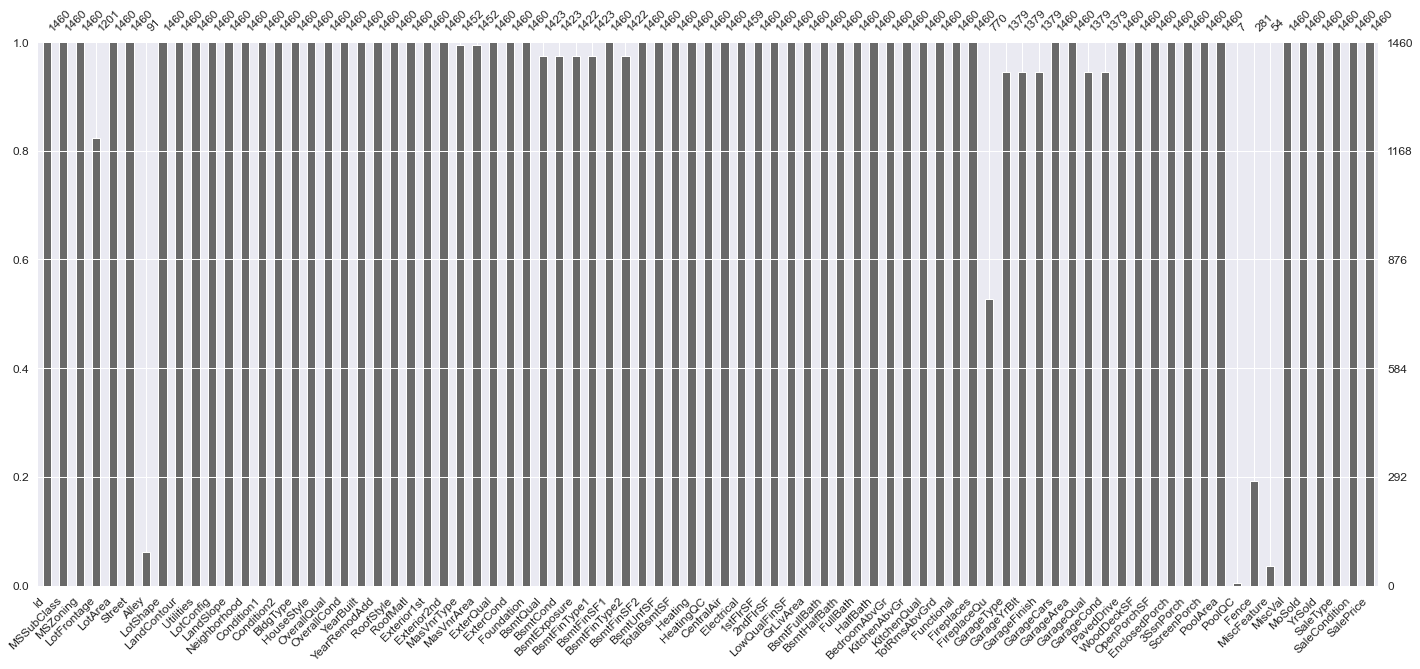

In [3]:
msno.bar(data, labels=True, fontsize=12);

In the very beginning I have decided entirely drop Alley, PoolQC, Fence and MiscFeature features because majority of values are missing.

In [4]:
features_to_drop = ["Alley", "PoolQC", "Fence", "MiscFeature"]
cleaned_data = data.drop(columns=features_to_drop)

Assuming that majority of lot areas in one neighborhood are more or less similar, I have filled missing values in LotFrontage column by most frequent value of particular neighborhood. 

In [5]:
cleaned_data["LotFrontage"] = cleaned_data["LotFrontage"].fillna(cleaned_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.value_counts().index[0]))

In [6]:
print("Most frequent value in MasVnrType column:", cleaned_data["MasVnrType"].mode()[0])
print("Most frequent value in MasVnrAre column:", cleaned_data["MasVnrArea"].mode()[0])

Most frequent value in MasVnrType column: None
Most frequent value in MasVnrAre column: 0.0


In [7]:
print("Number of most frequent value in MasVnrType column:", cleaned_data[cleaned_data["MasVnrType"] == "None"].shape[0])
print("Number of most frequent value in MasVnrAre column:", cleaned_data[cleaned_data["MasVnrArea"] == 0.0].shape[0])

Number of most frequent value in MasVnrType column: 864
Number of most frequent value in MasVnrAre column: 861


More than a half of values in both MasVnrType and MasVnrAre columns are None or 0.0 respectively. Also I made a technical assumption that masonry type depends on RoofStyle, RoofMatl and Exterior1st or vice versa. So the most frequent values of latter features, which also are values of coresponding rows with missing values in MasVnrType and MasVnrAre columns, are None and 0.0.

In [8]:
cleaned_data["MasVnrType"] = cleaned_data["MasVnrType"].fillna("None")
cleaned_data["MasVnrArea"] = cleaned_data["MasVnrArea"].fillna(0.0)

About 40 values are missing which are related to the features of basement and according to data description file this means that the house has no basement, so I have changed these NA values to None.

In [9]:
basement_features = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]

for feature in basement_features:
    cleaned_data[feature] = cleaned_data[feature].fillna("None")

NA value in the FireplaceQu column means that house has no fireplace so I have changed these NA values to None.

In [10]:
cleaned_data["FireplaceQu"] = cleaned_data["FireplaceQu"].fillna("None")

NA values in features which are related to garage also corresponds that house has no garage, so I have changed these NA values to None.

In [11]:
garage_features = ["GarageType", "GarageYrBlt", "GarageFinish", "GarageQual", "GarageCond"]

for feature in garage_features:
    cleaned_data[feature] = cleaned_data[feature].fillna("None")

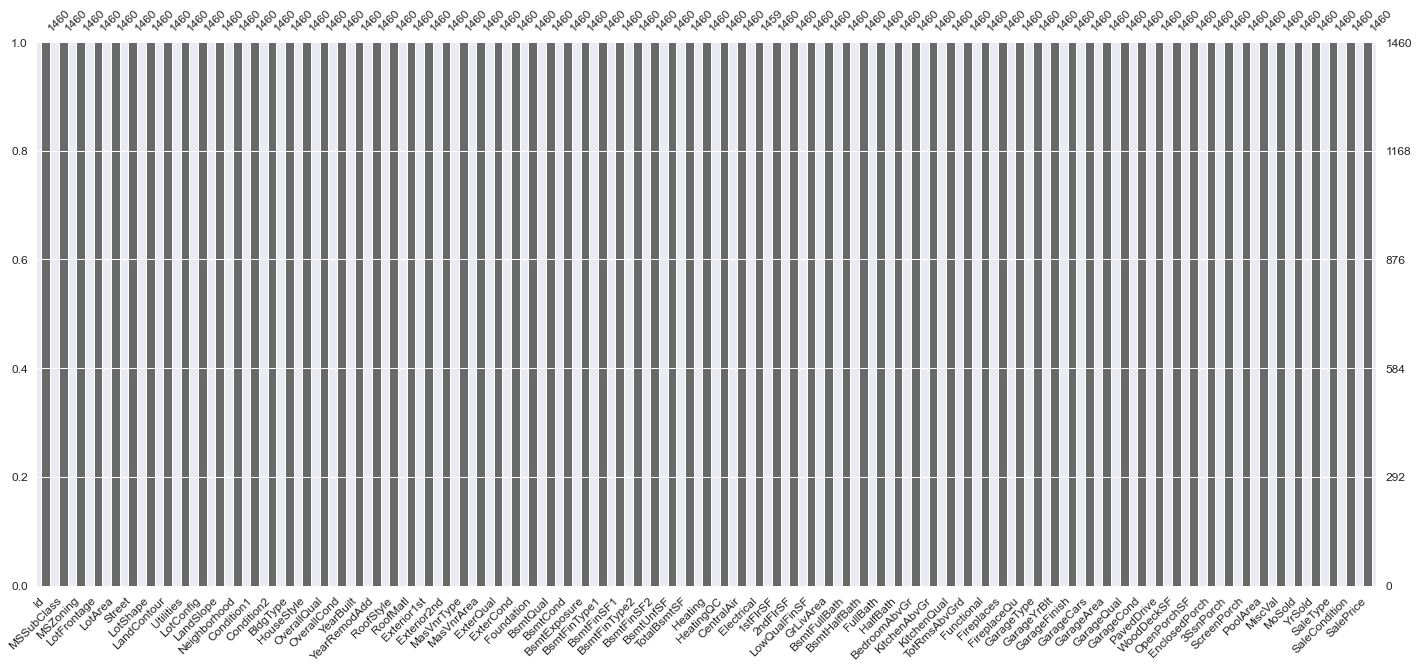

In [12]:
msno.bar(cleaned_data, labels=True, fontsize=12);

# Feature engineering

## Feature encoding

Some categorical features have clear order, therefore I have decided to map that values with numbers in sequence. 

In [13]:
quality_mapping = {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
quality_features = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond"]

for feature in quality_features:
    cleaned_data[feature] = cleaned_data[feature].map(quality_mapping)